# Forecast Forward with LGBM
Feature Engineering:
 - Datetime extraction
 - Introduce Phases
 - Use predicted average daily temperature to help fit model.

With LGBM, I will forecast up to March-31-2021. On January-01-2021, I'll change the Phases from Phase 4 to:
1. Phase -1: Coronavirus is over, return back to normal
2. Phase 4: Continue with Phase 4
3. Lockdown: Initiate Lockdown for January, and reopen on February

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

### Data Preprocessing
The original dataset can be found from data.ny.gov and time ranges from 2010-2020. <br>
https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga <br>
The counts are in hourly form and need to be resampled to Daily.
In addition, the bridges('plaza_id') are coded numerically and need to be renamed. <br>
Please note: I have combined Triboro Manhattan and Triboro Bronx into Triboro.

On 2017, NYC finished installing cashless tolls. I will, therefore, use data from 2018 and on because data was collected differently prior to 2017.

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [3]:
df = return_series('mta.csv')

### 9 Toll Bridges in NYC

There are some days when there were 0 crossings over bridges. (missing values). <br> For this project, I have decided to fill the missing values with the previous day count. <br>





In [4]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

### Feature Engineering: Holidays
Holidays will be an important feature in determining daily toll traffic. I created a list of all the holidays from 2018-2021.

In [92]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020, 2021]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']

### Feature Engineering: Date Features
From datetime, I extract the month, day of the week, year, weekend... etc. <br> In addition, I have included the 8 events that occurred in **2020**
0. March 12 - Events with more than 500 people cancelled
1. March 22 - NYS Pause Program begins, all non-essential workers must stay home
2. April 16 - Governor Cuomo extendes the stay-at-home order and school closures to May 15
3. May 15 - Governor Cuomo extends PAUSE to May 28
4. June 8 - NYC begins Phase 1 opening
5. June 22 - NYC begins Phase 2 opening
6. July 7 - NYC begins Phase 3 opening
7. July 19 - NYC begins Phase 4 opening

The timeline was extracted from investopedia. <br>
https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [6]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [7]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(1000, 19)


plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286,1,0,2018,1,1,1,1,-1,0,1
2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211,1,1,2018,1,2,1,2,-1,0,0
2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974,1,2,2018,1,3,1,3,-1,0,0
2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114,1,3,2018,1,4,1,4,-1,0,0
2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229,1,4,2018,1,5,1,5,-1,0,0


### Feature Engineer: Average Daily Temperatures
I will predict the average daily temperature from 2018 to current and use the y_hat values as a feature. The temperature data will train from 2010 to 2018.

The dataset comes from https://w2.weather.gov/climate/xmacis.php?wfo=okx with JFK, NY selected.
It ranges from 2010-2020. I will be only taking temp_average of each day.
The dataset will be made applicable via kaggle.


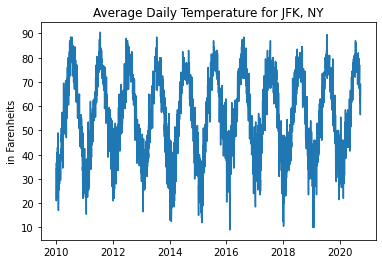

In [8]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

I'll do a quick forecasting on average daily temperature using FBProphet. <br>
Training set was 2010-2017, Testing set: 2018-2020

In [9]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [10]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [11]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

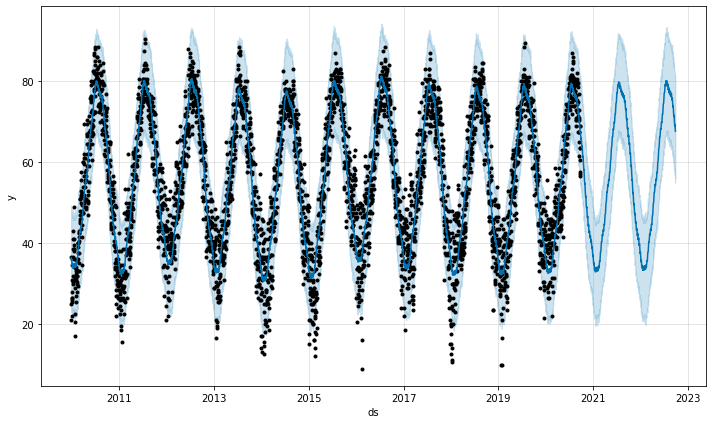

In [12]:
fig1 = m.plot(forecast)

In [13]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2018-01-01', end='2021-12-31'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [14]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.tail()

,temp_average
datetime,
2021-12-27,37.435564
2021-12-28,37.804732
2021-12-29,37.412938
2021-12-30,36.751722
2021-12-31,36.133309


In [15]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')
_df.reset_index(inplace=True)
_df.head()

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
0,2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286
1,2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211
2,2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974
3,2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114
4,2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229


In [16]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)


In [17]:
# LGBM doesn't take the string form in categorical values
le = LabelEncoder()
_df_melt['plaza_id'] = le.fit_transform(_df_melt['plaza_id'])


In [18]:
_df_melt = date_features(_df_melt)
_df_melt = _df_melt.join(sliced_forecast)
# There are many instances where I'll set an index to datetime and reset it.
# This is my fault for not making the data preprocessing functions take the same columns. For example: date_features takes index, while date_lag takes the column
_df_melt.reset_index(inplace=True)

In [19]:
_df_melt.tail()

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
8995,2020-09-26,4,60331,9,5,2020,39,26,3,270,7,1,0,65.793937
8996,2020-09-26,5,112860,9,5,2020,39,26,3,270,7,1,0,65.793937
8997,2020-09-26,6,165476,9,5,2020,39,26,3,270,7,1,0,65.793937
8998,2020-09-26,7,98894,9,5,2020,39,26,3,270,7,1,0,65.793937
8999,2020-09-26,8,135578,9,5,2020,39,26,3,270,7,1,0,65.793937


In [20]:
# Copying _df_melt as training_set
train_set = _df_melt.copy(deep=True)



In [21]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19') & (_df.index < '2021-01-01'),

    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7

    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [22]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
    _df['lag_7'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
    _df['lag_28'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)

    
    
    _df['mean_lag7_roll7'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [23]:
train_set = date_lags(train_set)
train_set.tail()

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
8995,2020-09-26,4,60331,9,5,2020,39,26,3,270,7,1,0,65.793937,55178.0,41910.0,63894.285714,61973.571429,60658.142857,59730.571429
8996,2020-09-26,5,112860,9,5,2020,39,26,3,270,7,1,0,65.793937,109976.0,93826.0,104571.428571,107936.035714,106931.142857,105696.464286
8997,2020-09-26,6,165476,9,5,2020,39,26,3,270,7,1,0,65.793937,162883.0,126361.0,159978.714286,157631.535714,154114.714286,154257.428571
8998,2020-09-26,7,98894,9,5,2020,39,26,3,270,7,1,0,65.793937,97866.0,84500.0,97605.428571,97837.642857,97222.428571,96337.857143
8999,2020-09-26,8,135578,9,5,2020,39,26,3,270,7,1,0,65.793937,132197.0,107399.0,124959.571429,125109.607143,125472.142857,124273.607143


In [24]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'year', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [25]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [26]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


In [27]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 38,
    'num_leaves': 83,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.5163386620025411,
    'feature_fraction': 0.8282029364551513,
    'lambda_l1' : 0.32608335857159515,
    'lambda_l2' : 0.47993551029860304,
    'verbosity': 1

}
# params taken from optuna
# {'max_depth': 38, 'num_leaves': 83, 'bag_frac': 0.5163386620025411, 'feat_frac': 0.8282029364551513, 'l1': 0.32608335857159515, 'l2': 0.47993551029860304}

In [28]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10573.7
[200]	valid_0's rmse: 8579.32
[300]	valid_0's rmse: 7521.3
[400]	valid_0's rmse: 7101.7
[500]	valid_0's rmse: 6857.95
[600]	valid_0's rmse: 6780.61
[700]	valid_0's rmse: 6714.65
[800]	valid_0's rmse: 6675.31
[900]	valid_0's rmse: 6653.37
[1000]	valid_0's rmse: 6642.66
[1100]	valid_0's rmse: 6630.1
[1200]	valid_0's rmse: 6623.78
[1300]	valid_0's rmse: 6620.21
[1400]	valid_0's rmse: 6616.92
[1500]	valid_0's rmse: 6614.62
[1600]	valid_0's rmse: 6610.77
[1700]	valid_0's rmse: 6610.78
[1800]	valid_0's rmse: 6608.11
[1900]	valid_0's rmse: 6608.98
[2000]	valid_0's rmse: 6611.83
[2100]	valid_0's rmse: 6610.72
[2200]	valid_0's rmse: 6610.22
[2300]	valid_0's rmse: 6611.56
Early stopping, best iteration is:
[1836]	valid_0's rmse: 6607.8


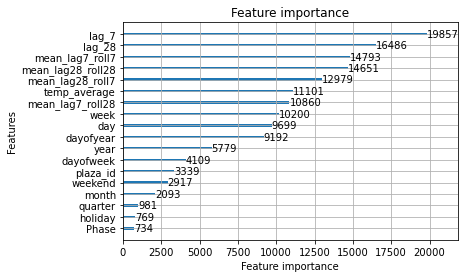

In [29]:
lgb.plot_importance(m_lgb)

### Creating the Prediction set

In [30]:
pred_set = pd.DataFrame(index = pd.date_range(start = '2020-09-27', end='2021-03-31') )
for i in bridges:
    pred_set[i] = np.nan
    
pred_set.reset_index(inplace=True)
pred_set.rename(columns={'index':'datetime'}, inplace=True)
pred_set.tail()

,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
181,2021-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,2021-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,2021-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,2021-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_pred_melt = pd.melt(pred_set, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone'])
_pred_melt.set_index('datetime', inplace=True)
_pred_melt['variable'] = le.transform(_pred_melt['variable'])
_pred_melt.tail()

,variable,value
datetime,,
2021-03-27,8,NaN
2021-03-28,8,NaN
2021-03-29,8,NaN
2021-03-30,8,NaN
2021-03-31,8,NaN


In [32]:
def date_features_pred(_df, jan, feb, march):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19') & (_df.index < '2021-01-01'),
        # alternate each month for Q1 2021
        (_df.index >= '2021-01-01') & (_df.index < '2021-02-01'),
        (_df.index >= '2021-02-01') & (_df.index < '2021-03-01'),
        (_df.index >= '2021-03-01')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        # alternate each month for Q1 2021
        jan,
        feb,
        march
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [33]:
def pred_lgbm_dataframe(dataframe):
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = dataframe.loc[dataframe['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')

    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-27', '2021-03-31'))][['datetime', 'plaza_id', 'value']]
    # _lgbm_pred
    _lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
    _lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
    # test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
    # test_set_pivot.columns = bridges
    _lgbm_pivot_pred['total'] = _lgbm_pivot_pred.sum(axis=1)

    return _lgbm_pivot_pred

### On January 01-2021: COVID over and return back to normal

In [34]:
_pred_melt_normal = date_features_pred(_pred_melt, -1, -1, -1)
_pred_melt_normal = _pred_melt_normal.join(sliced_forecast)
_pred_melt_normal.reset_index(inplace=True)
_pred_melt_normal.rename(columns={'variable': 'plaza_id'}, inplace=True)

In [35]:
_pred_melt_normal_df = pred_lgbm_dataframe(_pred_melt_normal)
_pred_melt

 37%|███▋      | 186/499 [00:12<00:21, 14.32it/s]


end of loop


,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,
2020-09-27,0,NaN,9,6,2020,39,27,3,271,7,1,0
2020-09-28,0,NaN,9,0,2020,40,28,3,272,7,0,0
2020-09-29,0,NaN,9,1,2020,40,29,3,273,7,0,0
2020-09-30,0,NaN,9,2,2020,40,30,3,274,7,0,0
2020-10-01,0,NaN,10,3,2020,40,1,4,275,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,8,NaN,3,5,2021,12,27,1,86,-1,1,0
2021-03-28,8,NaN,3,6,2021,12,28,1,87,-1,1,0
2021-03-29,8,NaN,3,0,2021,13,29,1,88,-1,0,0


### On January 01-2021: Continue Phase 4

In [36]:
_pred_melt_phase4 = date_features_pred(_pred_melt, 7, 7, 7)
_pred_melt_phase4 = _pred_melt_phase4.join(sliced_forecast)
_pred_melt_phase4.reset_index(inplace=True)
_pred_melt_phase4.rename(columns={'variable': 'plaza_id'}, inplace=True)

In [37]:
_pred_melt_phase4_df = pred_lgbm_dataframe(_pred_melt_phase4)

 37%|███▋      | 186/499 [00:13<00:21, 14.29it/s]


end of loop


### On January 01-2021: Lockdown and reopen on February

In [38]:
_pred_melt_lockdown = date_features_pred(_pred_melt, 1, 4, 7)
_pred_melt_lockdown = _pred_melt_lockdown.join(sliced_forecast)
_pred_melt_lockdown.reset_index(inplace=True)
_pred_melt_lockdown.rename(columns={'variable': 'plaza_id'}, inplace=True)

In [39]:
_pred_melt_lockdown_df = pred_lgbm_dataframe(_pred_melt_lockdown)

 37%|███▋      | 186/499 [00:13<00:23, 13.37it/s]


end of loop


In [40]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = _pred_melt.loc[_pred_melt['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

  0%|          | 0/499 [00:00<?, ?it/s]


end of loop


In [41]:
_df.set_index('datetime', inplace=True)
_df['total'] = _df.sum(axis=1)
_df.reset_index(inplace=True)
# _df

In [42]:

_2019_Q1_mean = _df.loc[(_df['datetime'] >= '2019-01-01') & (_df['datetime'] <= '2019-03-31')]['total'].mean()
_2019_Q1_mean

748047.088888889

In [130]:
_pred_melt_phase4_df['2021':]

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total
datetime,,,,,,,,,,
2021-01-01,41905.608044,19055.784306,51570.618111,18324.364461,61502.195987,113020.477745,147736.801645,88954.725751,124550.553009,666621.129058
2021-01-02,41238.224932,16989.364232,57684.163485,15215.606500,63387.801916,103884.078953,136618.555736,93565.264291,117631.985848,646215.045892
2021-01-03,40253.635134,15875.491182,50417.233722,14563.437221,58621.175736,100153.279057,133127.701706,84336.380024,115491.341998,612839.675779
2021-01-04,46813.358165,21074.185757,51969.830683,19658.146836,61983.047811,92580.272582,126683.106511,86986.290699,107204.087368,614952.326412
2021-01-05,49960.858444,21406.951031,58394.521133,20209.275420,65244.051082,98200.468521,137092.585159,93579.643200,113153.743105,657242.097096
...,...,...,...,...,...,...,...,...,...,...
2021-03-27,41442.761116,19143.076394,51194.000858,17183.908072,59493.711726,102658.930363,146373.217282,92421.814964,112022.324456,641933.745233
2021-03-28,41735.215968,17594.745888,45593.946434,16434.238353,56579.645276,99069.219122,134681.606863,82419.458242,107600.808664,601708.884810
2021-03-29,50788.560730,22250.947503,57088.673635,20100.375953,64482.766044,103706.166574,136967.028021,90968.672867,109325.574148,655678.765475


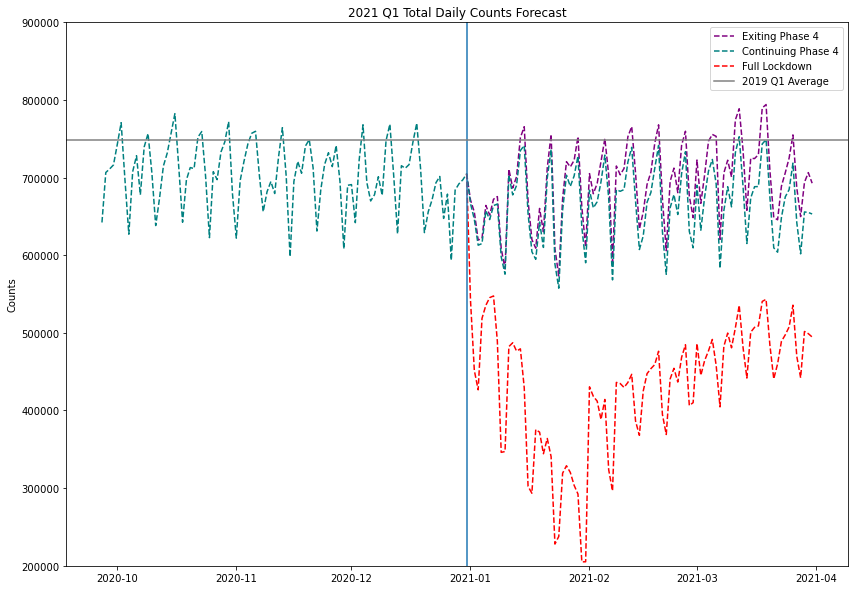

In [89]:
plt.figure(figsize=(14,10))
# plt.plot(sliced_plotting['Day_of_Year'], sliced_plotting['total'], label = '2019 actual')

plt.plot(_pred_melt_normal_df['2020-12-31':].index, _pred_melt_normal_df['2020-12-31':]['total'], label = 'Exiting Phase 4', color = 'purple',linewidth=1.5, linestyle = '--')
plt.plot(_pred_melt_phase4_df.index, _pred_melt_phase4_df['total'], label = 'Continuing Phase 4', color = 'teal',linewidth=1.5, linestyle = '--')
plt.plot(_pred_melt_lockdown_df['2020-12-31':].index, _pred_melt_lockdown_df['2020-12-31':]['total'], label = 'Full Lockdown', color = 'red',linewidth=1.5, linestyle = '--')
# plt.plot(_pred_melt_lockdown_df[:'2020-12-31'].index, _pred_melt_lockdown_df[:'2020-12-31']['total'], color = 'orange', linestyle = '--')
# Draw pivot line
plt.axvline(pd.to_datetime('2020-12-31'))
# Draw 2019 Q1 average counts
plt.axhline(_2019_Q1_mean, color='grey', label = '2019 Q1 Average')
plt.legend(loc = 'upper right')
plt.title('2021 Q1 Total Daily Counts Forecast')
plt.ylabel('Counts')
plt.ylim(200_000, 900_000)
plt.savefig('2021Q1forecast', bbox_inches ='tight', pad_inches=0.5);

In [44]:
_2019_Q1_sum = _df.loc[(_df['datetime'] >= '2019-01-01') & (_df['datetime'] <= '2019-03-31')]['total'].sum()
_2019_Q1_sum

67324238

In [45]:
_pred_melt_normal_df['2021-01-01':]['total'].sum()

62437709.956466906

In [46]:
_pred_melt_phase4_df['2021-01-01':]['total'].sum()

59917217.139752604

In [48]:
_pred_melt_lockdown_df['2021-01-01':]['total'].sum()

38760724.39606447

In [54]:
_2020_pred = _pred_melt_phase4_df.copy(deep=True)
_actual = _df.copy(deep=True)
_actual.set_index('datetime', inplace=True)
_2020_pred['dayofyear'] = _2020_pred.index.dayofyear
_actual['dayofyear'] = _actual.index.dayofyear

In [61]:
_actual['2019-01-01':'2019-12-31']

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total,dayofyear
datetime,,,,,,,,,,,
2019-01-01,32230,14627,47739,13571,59462,96937,135134,83742,112301,595743,1
2019-01-02,48068,22600,62609,20122,70871,109748,160710,100674,122673,718075,2
2019-01-03,52421,23462,65233,21583,72222,111448,168800,102714,125141,743024,3
2019-01-04,52650,24178,68276,21379,73413,114423,171435,104293,128479,758526,4
2019-01-05,37276,18274,52617,15030,61060,101257,140806,89136,113044,628500,5
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,47674,20901,67397,19433,73799,117317,179065,108885,137894,772365,361
2019-12-28,41165,17922,65985,16325,69772,120621,169005,105031,131937,737763,362
2019-12-29,40876,15156,58086,14769,64920,107968,154170,96541,124100,676586,363


In [66]:
_2020_pred[:'2020-12-31']['total'].mean()

702264.8003868255

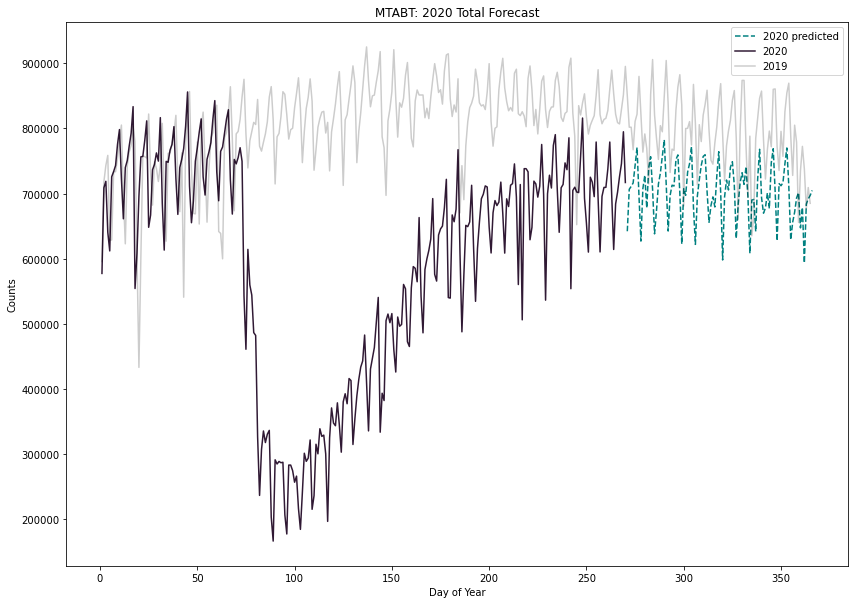

In [85]:


plt.figure(figsize=(14,10))
plt.plot(_2020_pred[:'2020-12-31']['dayofyear'], _2020_pred[:'2020-12-31']['total'], color = 'teal', linewidth=1.5,linestyle = '--', label= '2020 predicted')
plt.plot(_actual['2020-01-01':]['dayofyear'], _actual['2020-01-01':]['total'], color = '#301934',label = '2020')

plt.plot(_actual['2019-01-01':'2019-12-31']['dayofyear'], _actual['2019-01-01':'2019-12-31']['total'], color = 'black', alpha = 0.2, label = '2019')
plt.legend(loc='upper right')
plt.xlabel('Day of Year')
plt.ylabel('Counts')
plt.title('MTABT: 2020 Total Forecast')
# _percent_change = (_2020_pred[:'2020-12-31']['total'].mean() - _actual['2019-01-01':'2019-12-31']['total'].mean())/_actual['2019-01-01':'2019-12-31']['total'].mean() * 100
# plt.annotate('{:.2f}%'.format(_percent_change), xy=(0.55, 0.10), xycoords='axes fraction', fontsize=70, color = 'orange')
plt.savefig('Total_forecast', bbox_inches ='tight', pad_inches=0.5)


In [98]:
pred_set_far = pd.DataFrame(index = pd.date_range(start = '2020-09-27', end='2021-12-31') )
for i in bridges:
    pred_set_far[i] = np.nan
    
pred_set_far.reset_index(inplace=True)
pred_set_far.rename(columns={'index':'datetime'}, inplace=True)
pred_set_far.tail()

,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
456,2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,2021-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
_pred_melt_phase4_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total
datetime,,,,,,,,,,
2020-09-27,38018.675960,18933.434857,52183.212710,18558.828581,52772.957028,110162.670869,142622.105993,84166.173766,124683.498649,642101.558414
2020-09-28,51362.858236,20728.248465,57998.586890,19840.701269,66660.244136,106652.878246,164566.931643,96015.154356,122642.748280,706468.351521
2020-09-29,51219.153493,20714.258985,59379.076219,20406.806203,67516.281526,104427.221875,161354.284375,99212.446272,126778.023851,711007.552799
2020-09-30,49175.201071,21691.530443,62983.408857,20920.249248,67959.452765,104613.672935,165690.607463,98789.782629,124373.945458,716197.850869
2020-10-01,53481.193254,21616.728209,67718.844969,20621.191658,74400.352668,107882.583469,170427.837770,99609.865434,127066.082734,742824.680166
...,...,...,...,...,...,...,...,...,...,...
2021-03-27,41442.761116,19143.076394,51194.000858,17183.908072,59493.711726,102658.930363,146373.217282,92421.814964,112022.324456,641933.745233
2021-03-28,41735.215968,17594.745888,45593.946434,16434.238353,56579.645276,99069.219122,134681.606863,82419.458242,107600.808664,601708.884810
2021-03-29,50788.560730,22250.947503,57088.673635,20100.375953,64482.766044,103706.166574,136967.028021,90968.672867,109325.574148,655678.765475


In [138]:
forecast_avg_bridges = []
for i in bridges:
    forecast_avg_bridges.append((_pred_melt_phase4_df['2021':][i].mean(), i))

In [139]:
forecast_avg_bridges

[(50233.07837482333, 'Brooklyn Battery'),
 (20764.639291365616, 'Cross Bay'),
 (56323.89184903462, 'Henry Hudson'),
 (19096.573653358537, 'Marine Parkway'),
 (66407.48088122647, 'Queens Midtown'),
 (101821.54703443164, 'Throgs Neck'),
 (147806.27663695678, 'Triboro'),
 (92277.43288724328, 'Verrazano'),
 (111015.93649992201, 'Whitestone')]

In [142]:
_2019_avg_bridges = []
for i in bridges:
    _2019_avg_bridges.append((_actual['2019-01-01':'2019-03-31'][i].mean(),i))

In [143]:
_2019_avg_bridges

[(51980.955555555556, 'Brooklyn Battery'),
 (21494.022222222222, 'Cross Bay'),
 (66096.16666666667, 'Henry Hudson'),
 (19337.666666666668, 'Marine Parkway'),
 (79188.12222222223, 'Queens Midtown'),
 (113509.32222222222, 'Throgs Neck'),
 (172507.03333333333, 'Triboro'),
 (98719.66666666667, 'Verrazano'),
 (125214.13333333333, 'Whitestone')]

In [150]:
for forecast, actual in zip(forecast_avg_bridges, _2019_avg_bridges):
    print(forecast[1],' : ',(forecast[0] - actual[0])/ actual[0])

Brooklyn Battery  :  -0.03362533762704981
Cross Bay  :  -0.03393422242313082
Henry Hudson  :  -0.14784934301735178
Marine Parkway  :  -0.012467533827321343
Queens Midtown  :  -0.1613959389658211
Throgs Neck  :  -0.10296753569639777
Triboro  :  -0.14318695428868433
Verrazano  :  -0.06525785587562818
Whitestone  :  -0.11339132776340999


### Forecasting all of 2021
Given that NYC stays in Phase 4 for the rest of the year, forecast all of 2021. <br>
_This idea has been scrapped._

In [103]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_pred_far_melt = pd.melt(pred_set_far, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone'])
_pred_far_melt.set_index('datetime', inplace=True)
_pred_far_melt['variable'] = le.transform(_pred_far_melt['variable'])
_pred_far_melt.tail()

,variable,value
datetime,,
2021-12-27,8,NaN
2021-12-28,8,NaN
2021-12-29,8,NaN
2021-12-30,8,NaN
2021-12-31,8,NaN


In [104]:
# _pred_far_melt.reset_index(inplace=True)

In [105]:

_pred_far_melt = date_features_pred(_pred_far_melt, 7, 7, 7)
_pred_far_melt = _pred_far_melt.join(sliced_forecast)
_pred_far_melt.reset_index(inplace=True)
_pred_far_melt.rename(columns={'variable': 'plaza_id'}, inplace=True)
_pred_far_melt

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
0,2020-09-27,0,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
1,2020-09-27,1,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
2,2020-09-27,2,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
3,2020-09-27,3,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
4,2020-09-27,4,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,2021-12-31,4,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309
4145,2021-12-31,5,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309
4146,2021-12-31,6,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309
4147,2021-12-31,7,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309


In [110]:
def pred_far_dataframe(dataframe):
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = dataframe.loc[dataframe['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')

    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-27', '2021-12-31'))][['datetime', 'plaza_id', 'value']]
    # _lgbm_pred
    _lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
    _lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
    # test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
    # test_set_pivot.columns = bridges
    _lgbm_pivot_pred['total'] = _lgbm_pivot_pred.sum(axis=1)

    return _lgbm_pivot_pred

In [111]:
_pred_far_df = pred_far_dataframe(_pred_far_melt)

 92%|█████████▏| 461/499 [00:36<00:03, 12.50it/s]


end of loop


In [112]:
_pred_far_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total
datetime,,,,,,,,,,
2020-09-27,38018.675960,18933.434857,52183.212710,18558.828581,52772.957028,110162.670869,142622.105993,84166.173766,124683.498649,642101.558414
2020-09-28,51362.858236,20728.248465,57998.586890,19840.701269,66660.244136,106652.878246,164566.931643,96015.154356,122642.748280,706468.351521
2020-09-29,51219.153493,20714.258985,59379.076219,20406.806203,67516.281526,104427.221875,161354.284375,99212.446272,126778.023851,711007.552799
2020-09-30,49175.201071,21691.530443,62983.408857,20920.249248,67959.452765,104613.672935,165690.607463,98789.782629,124373.945458,716197.850869
2020-10-01,53481.193254,21616.728209,67718.844969,20621.191658,74400.352668,107882.583469,170427.837770,99609.865434,127066.082734,742824.680166
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,49930.575513,19986.125756,62125.882414,19516.324297,65662.737706,106329.062936,166610.571086,105339.912678,126067.160847,721568.353232
2021-12-28,49927.960863,19741.399558,60091.325067,18983.341091,64840.588810,109335.804274,164062.622564,105910.544806,126910.212007,719803.799040
2021-12-29,51694.743958,19904.035029,62814.132887,18948.352707,65845.066122,110902.528977,166489.432215,107061.343829,127581.908298,731241.544021


Text(0.5, 1.0, 'MTA Total Count: 2021 Forecast vs 2019 Actual')

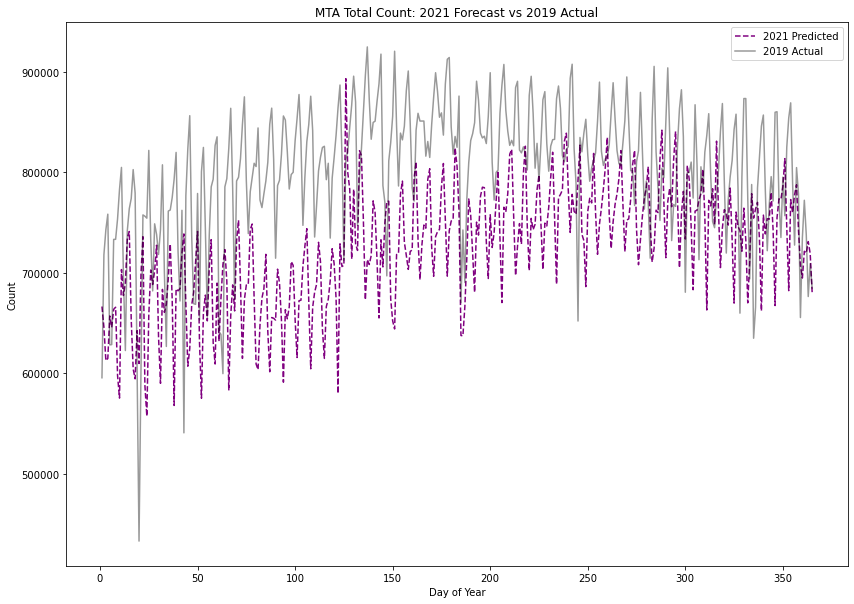

In [129]:
plt.figure(figsize=(14,10))
plt.plot(_pred_far_df['2021':].index.dayofyear, _pred_far_df['2021':]['total'], color = 'purple', linestyle='--', label = '2021 Predicted')
plt.plot(_actual['2019-01-01':'2019-12-31']['dayofyear'], (_actual['2019-01-01':'2019-12-31']['total']), color='black', alpha=0.4,label = '2019 Actual')
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('MTA Total Count: 2021 Forecast vs 2019 Actual')